In [1]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
sns.set_style("darkgrid")

In [51]:
df = pd.read_csv("data/model-counsel-chat-eng.csv", encoding='UTF8')
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,Unnamed: 0,topic,answer,split
0,1771,counseling-fundamentals,Let me start by saying there are never too man...,train
1,919,trauma,Have you explained to your prospective partner...,train
2,655,parenting,This is a common response parents can have. T...,train
3,1224,intimacy,"Hi Portland,This must feel like your world is ...",val
4,1960,self-harm,I like to take pictures of my sh and save them...,train


In [53]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    #text = re.sub(r'\-', ' ', text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    if predict_lang(text) == "en":
        text = nltk.word_tokenize(text)
        return text
    else:
        return []

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
lmtz = WordNetLemmatizer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [lmtz.lemmatize(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    res = stem_words(remove_stop_words(initial_clean(text)))
    return list(filter(lambda x: len(x) > 0, res))

In [52]:
textmodel = fasttext.load_model('lid.176.bin')

def predict_lang(sentence):
    return textmodel.predict([sentence])[0][0][-1][-2:]

In [54]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['answer'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")
print(type(df['tokenized']))

Time to clean and tokenize 1993 articles: 0.49907906850179035 min
<class 'pandas.core.series.Series'>


In [55]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

12810

In [98]:
# choose k and visually inspect the bottom 10 words of the top k
k = 1000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('wondering', 23),
 ('google', 23),
 ('missing', 23),
 ('law', 23),
 ('description', 23),
 ('judged', 23),
 ('greater', 23),
 ('lpc', 23),
 ('facing', 23),
 ('qualified', 23)]

In [99]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [100]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [101]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 1286 
average document length 75.9696734059098 
minimum document length 31 
maximum document length 348


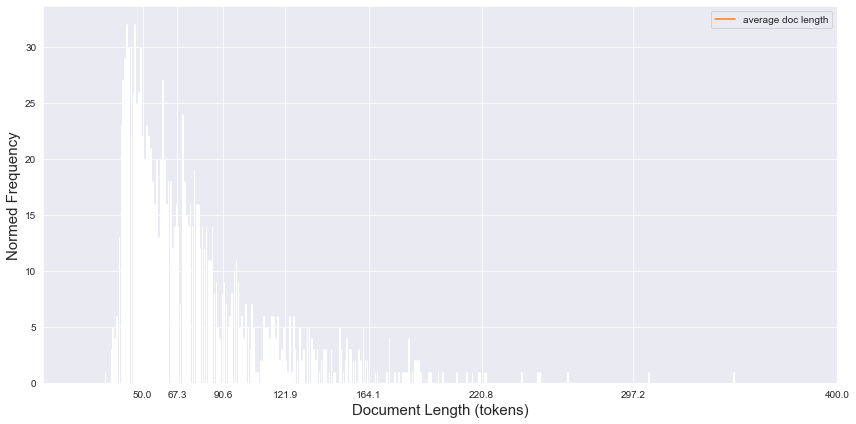

In [102]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(400),num=8, base=10.0))
plt.xlim(0,400)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [103]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 1231 articles


In [104]:
df.head()

,Unnamed: 0,topic,answer,split,tokenized
0,1771,counseling-fundamentals,Let me start by saying there are never too man...,train,"[let, start, saying, never, many, concern, bri..."
1,919,trauma,Have you explained to your prospective partner...,train,"[partner, feeling, youve, one, truth, trusted,..."
2,655,parenting,This is a common response parents can have. T...,train,"[common, response, parent, many, reason, impor..."
3,1224,intimacy,"Hi Portland,This must feel like your world is ...",val,"[hi, must, feel, like, world, wife, new, frien..."
4,1629,behavioral-change,Teenagers are prone to mood swings due to deve...,train,"[mood, due, change, body, mind, happens, many,..."


In [105]:
train_df = df[df['split'] == "train"]
test_df = df[df['split'] == "test"]
val_df = df[df['split'] == "val"]

In [106]:
print(len(df),len(train_df),len(test_df), len(val_df))

1231 1047 76 108


In [107]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 60
    chunksize = 90
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [108]:
dictionary,corpus,lda = train_lda(df)

Time to train LDA model on  1231 articles:  0.03676498333613078 min


In [109]:
topics = lda.show_topics(num_topics= -1, num_words=10, formatted=False)
sorted_topics = sorted(topics, key=lambda x: x[0])
#topic_prob = list(zip(topics, pred))
print(len(sorted_topics))

60


In [110]:
dictionary.save('ttk_models/text_to_keywords.dictionary')

In [111]:
print(sorted_topics)

[(0, [('care', 0.05837049), ('feeling', 0.057323437), ('feel', 0.03854421), ('mother', 0.032222368), ('boundary', 0.027504392), ('like', 0.026680881), ('emotional', 0.025794774), ('understand', 0.022895463), ('know', 0.02210343), ('youre', 0.020946162)]), (1, [('decision', 0.052159026), ('choice', 0.04089318), ('world', 0.038500015), ('regarding', 0.03616007), ('may', 0.034464713), ('one', 0.033562377), ('think', 0.033114806), ('instead', 0.030507239), ('another', 0.028623346), ('mean', 0.026929257)]), (2, [('anxiety', 0.29123598), ('depression', 0.15272065), ('symptom', 0.11615632), ('help', 0.056458607), ('experience', 0.029425899), ('news', 0.027899757), ('helpful', 0.025958207), ('body', 0.018722296), ('addressing', 0.018338911), ('tool', 0.017594231)]), (3, [('mind', 0.1255701), ('opinion', 0.10782363), ('sleep', 0.10474344), ('topic', 0.08225291), ('body', 0.08043901), ('attack', 0.07984277), ('panic', 0.0780969), ('keeping', 0.07656205), ('piece', 0.05419244), ('calm', 0.0391269

In [112]:
lda.save("ttk_models/text_to_keywords.model")

In [70]:
loaded_model = LdaModel.load('ttk_models/text_to_keywords.model')

In [2]:
from TextToKeywords import TextToKeywords

In [3]:
ttk = TextToKeywords()

In [4]:
texto = 'Hi, Break ups can be very devastating and even traumatic. Recovering from one is a process that is unique for everyone person and will take time. It is important that you do not compare yourself to others. Each and every person will experience this grieving process differently. Here are a few tips to help with your recovery: 1. Make sure you surround yourself with people who love you and support you, friends and family. Even though you might feel like being alone, make an effort to be around them. 2. Although you might not feel like it, try to take care of yourself as much as possible: eat healthily, get regular sleep, & vigorous or gentle exercise (depending on your mood). The last thing that we want to do when we are physically sick (e.g. flu) is to take care of ourselves even thought that is what we need the most. But when we do get that chicken broth, sleep and vitamins we recover much faster and with less discomfort. That is exactly the same when it comes to emotional pain. Take care of yourself, keep yourself strong and healthy so you can recover faster. 3. As much as possible, put away reminders of the relationship. You might not be ready to throw things out, but try to put them away in a box in the storage or in a closet. And also block Social Media reminders. There is a lot of wisdom in the saying "Out of Sight, Out of Mind." 4. Once the initial shock and intensity of the break up wear off, try out something new. In a relationship, we often forget and give up on things that we always wanted to do or to try. Now it is time to bring out that dusty bucket list and start trying something new. 5. If possible, change your scenery by going away on vacation with a friend or even by yourself. Changing your surroundings can really help you change your thoughts, mindset and forget your ex even if just for a few hours. Even a weekend getaway with a couple of girlfriends can do wonders. 6. In addition, to help you make sense of your past relationship and what went wrong, I would highly recommend seeing a professional counsellor or therapist.'
ttk.predict(texto)

['people', 'love', 'someone', 'dont', 'want', 'life', 'way', 'person', 'feeling', 'even']
